In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import plotly.express as px
import plotly.graph_objects as go
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 1️ Loading Annotated Data (MG_D.csv)
df_resampled = pd.read_csv('../data/Marion.lnk/MG_D.csv')
df_resampled.columns = ['date_time', 'X', 'Y', 'Z']
df_resampled['date_time'] = pd.to_datetime(df_resampled['date_time'])
df_resampled.set_index('date_time', inplace=True)

# 2️ Loading Activity Log (activity_M.csv)
activity = pd.read_csv('../data/activity_M.csv', sep=';', skipinitialspace=True)
activity.columns = activity.columns.str.strip()
base_date = pd.to_datetime("2024-04-15")
activity['date'] = base_date + pd.to_timedelta(activity['jour'], unit='D')

# Function to clean time format
def clean_time(time_str):
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return np.nan  
    time_str = time_str.strip().replace("h", ":")
    if ":" not in time_str:
        return time_str + ":00"
    elif time_str.count(":") == 1:
        return time_str + ":00"
    return time_str

activity['debut'] = activity['debut'].astype(str).apply(clean_time)
activity['fin'] = activity['fin'].astype(str).apply(clean_time)
activity['debut'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['debut'], errors='coerce')
activity['fin'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['fin'], errors='coerce')
activity.drop(columns=['date'], inplace=True)

# Assign activity labels to accelerometer data
def label_activity(timestamp, activity):
    for _, row in activity.iterrows():
        if row['debut'] <= timestamp <= row['fin']:
            return row['activite']
    return "Other"

df_resampled['activity'] = df_resampled.index.map(lambda x: label_activity(x, activity))

# 3️ Loading New Unannotated Data (MG_D2.csv)
df2 = pd.read_csv('../data/Marion.lnk/MG_D2.csv')
df2.columns = ['date_time', 'X', 'Y', 'Z']
df2['date_time'] = pd.to_datetime(df2['date_time'])
df2.set_index('date_time', inplace=True)

# 4️ Applying a Low-Pass Filter to Remove Noise
fs, fc = 50, 10  # Sampling frequency = 50Hz, Cut-off = 10Hz
b, a = signal.butter(3, fc / (fs / 2), btype='low', analog=False)
df_resampled[['X', 'Y', 'Z']] = signal.filtfilt(b, a, df_resampled[['X', 'Y', 'Z']], axis=0)
df2[['X', 'Y', 'Z']] = signal.filtfilt(b, a, df2[['X', 'Y', 'Z']], axis=0)

# 5️ Training Shapelets on Annotated Data
window_size, step_size = 250, 125  # 5s window, 50% overlap
segments, labels = [], []

for _, row in activity.iterrows():
    start, end, label = row['debut'], row['fin'], row['activite']
    
    # Extract numerical columns only (X, Y, Z)
    segment = df_resampled.loc[start:end, ['X', 'Y', 'Z']]
    
    if len(segment) >= window_size:
        for i in range(0, len(segment) - window_size, step_size):
            segments.append(segment.iloc[i:i + window_size].values)  # Only numeric data
            labels.append(label)

# Convert X_train to a purely numerical NumPy array
X_train = np.array(segments, dtype=np.float32)  # Ensuring it is float32
y_train = np.array(labels)

# Convert activity labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert activity names to numbers

# Define shapelet sizes based on the dataset
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=len(X_train), ts_sz=X_train.shape[1], 
                                                       n_classes=len(set(y_train_encoded)), l=0.1, r=1)

shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes, optimizer="sgd", weight_regularizer=0.01, verbose=1)
shp_clf.fit(X_train, y_train_encoded)

# 6️ Classifying Activities in MG_D2.csv
segments_test = []

# Segmenting df2 into time windows
for i in range(0, len(df2) - window_size, step_size):
    segments_test.append(df2.iloc[i:i + window_size][['X', 'Y', 'Z']].values)  # Only numeric data

# Convert X_test to numerical format
X_test = np.array(segments_test, dtype=np.float32)
X_test_transformed = shp_clf.transform(X_test)

X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(shp_clf.transform(X_train), y_train_encoded, test_size=0.2, random_state=42)
clf = ShapeletTransformClassifier()
clf.fit(X_train_t, y_train_t)
y_pred_encoded = clf.predict(X_test_transformed)

# Convert predicted labels back to original activity names
y_pred = label_encoder.inverse_transform(y_pred_encoded)

df2['predicted_activity'] = np.nan
idx = 0
for i in range(0, len(df2) - window_size, step_size):
    df2.loc[df2.iloc[i:i + window_size].index, 'predicted_activity'] = y_pred[idx]
    idx += 1

# 7️ Visualizing Detected Activities
fig = px.scatter(df2, x=df2.index, y="X", color="predicted_activity", title="Detected Activities in MG_D2")
fig.show()

df2.to_csv('../data/Marion.lnk/MG_D2_pred.csv', index=True)



/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import plotly.express as px
import plotly.graph_objects as go
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 1️⃣ Loading Annotated Data (MG_D.csv)
df_resampled = pd.read_csv('../data/Marion.lnk/MG_D.csv')
df_resampled.columns = ['date_time', 'X', 'Y', 'Z']
df_resampled['date_time'] = pd.to_datetime(df_resampled['date_time'])
df_resampled.set_index('date_time', inplace=True)

# 2️⃣ Loading Activity Log (activity_M.csv)
activity = pd.read_csv('../data/activity_M.csv', sep=';', skipinitialspace=True)
activity.columns = activity.columns.str.strip()
base_date = pd.to_datetime("2024-04-15")
activity['date'] = base_date + pd.to_timedelta(activity['jour'], unit='D')

def clean_time(time_str):
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return np.nan  
    time_str = time_str.strip().replace("h", ":")
    if ":" not in time_str:
        return time_str + ":00"
    elif time_str.count(":") == 1:
        return time_str + ":00"
    return time_str

activity['debut'] = activity['debut'].astype(str).apply(clean_time)
activity['fin'] = activity['fin'].astype(str).apply(clean_time)
activity['debut'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['debut'], errors='coerce')
activity['fin'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['fin'], errors='coerce')
activity.drop(columns=['date'], inplace=True)

def label_activity(timestamp, activity):
    for _, row in activity.iterrows():
        if row['debut'] <= timestamp <= row['fin']:
            return row['activite']
    return "Other"

df_resampled['activity'] = df_resampled.index.map(lambda x: label_activity(x, activity))

# 3️⃣ Loading New Unannotated Data (MG_D2.csv)
df2 = pd.read_csv('../data/Marion.lnk/MG_D2.csv')
df2.columns = ['date_time', 'X', 'Y', 'Z']
df2['date_time'] = pd.to_datetime(df2['date_time'])
df2.set_index('date_time', inplace=True)

# 4️⃣ Applying a Low-Pass Filter to Remove Noise
fs, fc = 50, 10
b, a = signal.butter(3, fc / (fs / 2), btype='low', analog=False)
df_resampled[['X', 'Y', 'Z']] = signal.filtfilt(b, a, df_resampled[['X', 'Y', 'Z']], axis=0)
df2[['X', 'Y', 'Z']] = signal.filtfilt(b, a, df2[['X', 'Y', 'Z']], axis=0)

# 5️⃣ Training Shapelets on Activities "A", "P", and "Other"
window_size, step_size = 250, 125 
segments, labels = [], []

for _, row in activity.iterrows():
    start, end, label = row['debut'], row['fin'], row['activite']
    if label in ["A", "P"]:  # Keep only "A" and "P"
        segment = df_resampled.loc[start:end, ['X', 'Y', 'Z']]
        if len(segment) >= window_size:
            for i in range(0, len(segment) - window_size, step_size):
                segments.append(segment.iloc[i:i + window_size].values)
                labels.append(label)

# Add "Other" class by selecting non-labeled periods
other_segments = df_resampled[df_resampled['activity'] == "Other"]
for i in range(0, len(other_segments) - window_size, step_size):
    segments.append(other_segments.iloc[i:i + window_size][['X', 'Y', 'Z']].values)
    labels.append("Other")

X_train = np.array(segments, dtype=np.float32)
y_train = np.array(labels)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=len(X_train), ts_sz=X_train.shape[1], 
                                                       n_classes=len(set(y_train_encoded)), l=0.1, r=1)

shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes, optimizer="sgd", weight_regularizer=0.01, verbose=1)
shp_clf.fit(X_train, y_train_encoded)

# 6️⃣ Classifying Activities in the First 2 Days of MG_D2.csv
df2_filtered = df2[df2.index < df2.index.min() + pd.Timedelta(days=2)]
segments_test = []

for i in range(0, len(df2_filtered) - window_size, step_size):
    segments_test.append(df2_filtered.iloc[i:i + window_size][['X', 'Y', 'Z']].values)

X_test = np.array(segments_test, dtype=np.float32)
X_test_transformed = shp_clf.transform(X_test)

X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(shp_clf.transform(X_train), y_train_encoded, test_size=0.2, random_state=42)
clf = ShapeletTransformClassifier()
clf.fit(X_train_t, y_train_t)
y_pred_encoded = clf.predict(X_test_transformed)

y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Apply a confidence threshold to classify uncertain predictions as "Other"
df2_filtered['predicted_activity'] = np.nan
idx = 0
for i in range(0, len(df2_filtered) - window_size, step_size):
    df2_filtered.loc[df2_filtered.iloc[i:i + window_size].index, 'predicted_activity'] = y_pred[idx]
    idx += 1

# 7️⃣ Visualizing Detected Activities
fig = px.scatter(df2_filtered, x=df2_filtered.index, y="X", color="predicted_activity", title="Detected Activities in First 2 Days of MG_D2")
fig.show()

df2_filtered.to_csv('../data/Marion.lnk/MG_D2_pred_filtered.csv', index=True)


/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


KeyboardInterrupt: 

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.6440 - binary_crossentropy: 0.7691 - loss: 0.7841
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7066 - binary_crossentropy: 0.6116 - loss: 0.6221
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7645 - binary_crossentropy: 0.5469 - loss: 0.5565
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7613 - binary_crossentropy: 0.5213 - loss: 0.5311
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.7666 - binary_crossentropy: 0.5004 - loss: 0.5107
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7660 - binary_crossentropy: 0.4930 - loss: 0.5039
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7684 - binary_crossentropy: 0.4841 - loss: 0.4956
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.7653 - binary_crossentropy: 0.4821 - loss: 0.4940
Epoch 9/

/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/4012293973.py:163: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


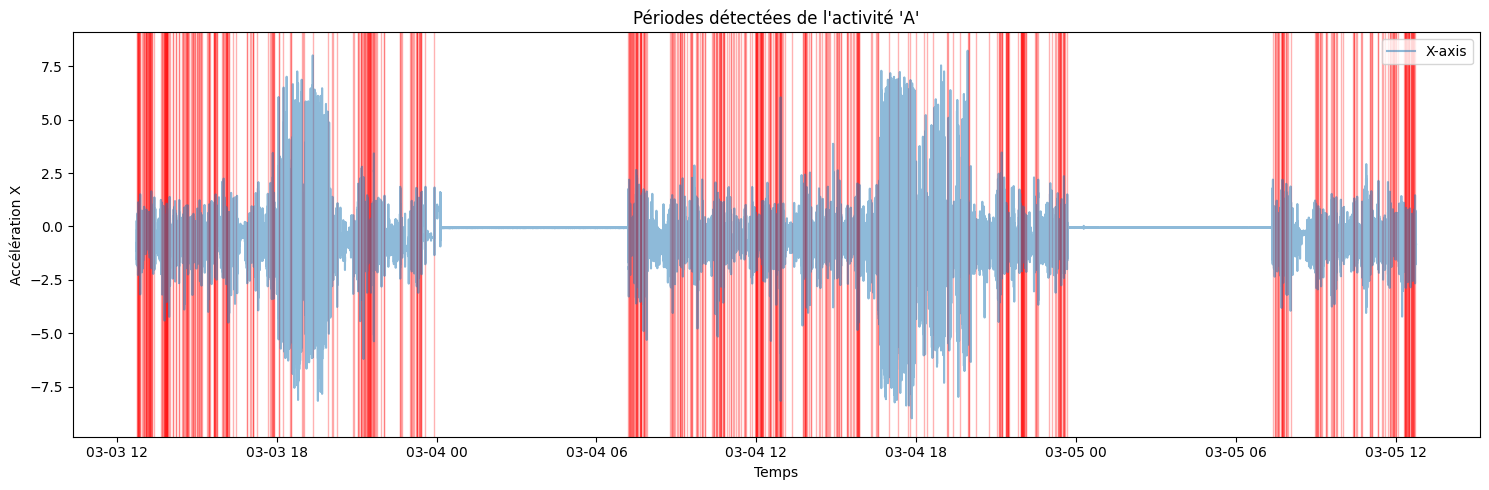

In [4]:
import numpy as np
import pandas as pd
import scipy.signal as signal
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ==== PARAMÈTRES ====
fs, fc = 50, 10  # fréquence d’échantillonnage et fréquence de coupure
window_size, step_size = 250, 125  # taille des fenêtres
target_activity = "A"
min_duration_sec = 5
merge_gap_sec = 10

# ==== FONCTIONS ====

def butter_lowpass_filter(df, columns):
    b, a = signal.butter(3, fc / (fs / 2), btype='low')
    df[columns] = signal.filtfilt(b, a, df[columns], axis=0)
    return df

def load_accel_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['date_time', 'X', 'Y', 'Z']
    df['date_time'] = pd.to_datetime(df['date_time'])
    df.set_index('date_time', inplace=True)
    return butter_lowpass_filter(df, ['X', 'Y', 'Z'])

def clean_activity_journal(filepath):
    act = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    act.columns = act.columns.str.strip()
    act['date'] = pd.to_datetime("2024-04-15") + pd.to_timedelta(act['jour'], unit='D')

    def clean_time(t):
        if pd.isna(t) or not isinstance(t, str) or t.strip() == "":
            return np.nan
        t = t.strip().replace("h", ":")
        return t if ":" in t else t + ":00"

    act['debut'] = pd.to_datetime(act['date'].astype(str) + " " + act['debut'].astype(str).apply(clean_time), errors='coerce')
    act['fin'] = pd.to_datetime(act['date'].astype(str) + " " + act['fin'].astype(str).apply(clean_time), errors='coerce')
    return act

def segment_and_label(df, act, target="A"):
    segments, labels = [], []

    # Activité cible
    for _, row in act[act['activite'] == target].iterrows():
        segment = df.loc[row['debut']:row['fin'], ['X', 'Y', 'Z']]
        for i in range(0, len(segment) - window_size, step_size):
            segments.append(segment.iloc[i:i + window_size].values)
            labels.append(target)

    # Données hors "A"
    not_A_df = df.copy()
    for _, row in act[act['activite'] == target].iterrows():
        not_A_df = not_A_df.drop(df.loc[row['debut']:row['fin']].index, errors='ignore')

    for i in range(0, len(not_A_df) - window_size, 1000):
        seg = not_A_df.iloc[i:i + window_size][['X', 'Y', 'Z']].values
        if np.std(seg) > 0.02:
            segments.append(seg)
            labels.append(f"not_{target}")
    return np.array(segments, dtype=np.float32), np.array(labels)

def postprocess_predictions(timestamps, preds, min_dur=5, merge_gap=10):
    df_preds = pd.DataFrame({'timestamp': timestamps, 'prediction': preds})
    df_preds['prediction'] = df_preds['prediction'].astype(str)

    periods = []
    current_start = None
    for i in range(len(df_preds)):
        if df_preds.loc[i, 'prediction'] == target_activity:
            if current_start is None:
                current_start = df_preds.loc[i, 'timestamp']
        else:
            if current_start:
                end_time = df_preds.loc[i - 1, 'timestamp']
                periods.append((current_start, end_time))
                current_start = None
    if current_start:
        periods.append((current_start, df_preds.iloc[-1]['timestamp']))

    # Nettoyage post-prédiction
    cleaned = []
    for start, end in periods:
        duration = (end - start).total_seconds()
        if duration >= min_dur:
            if cleaned and (start - cleaned[-1][1]).total_seconds() <= merge_gap:
                cleaned[-1] = (cleaned[-1][0], end)  # fusion
            else:
                cleaned.append((start, end))
    return cleaned

# ==== PIPELINE ====

# Données annotées
df1 = load_accel_data('../data/Marion.lnk/MG_D.csv')
activity = clean_activity_journal('../data/activity_M.csv')
X, y = segment_and_label(df1, activity, target=target_activity)

# Encodage labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Shapelet model
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=len(X), ts_sz=X.shape[1], n_classes=2, l=0.1, r=1)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes, optimizer="sgd", weight_regularizer=0.01, max_iter=50, verbose=1)
shp_clf.fit(X, y_encoded)

# Logistic Regression
X_tr, X_val, y_tr, y_val = train_test_split(shp_clf.transform(X), y_encoded, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=200)
clf.fit(X_tr, y_tr)

print("\n=== Classification Report (Validation) ===")
print(classification_report(y_val, clf.predict(X_val), target_names=label_encoder.classes_))

# Données non annotées 
df2 = load_accel_data('../data/Marion.lnk/MG_D2.csv')
df2_filtered = df2[df2.index < df2.index.min() + pd.Timedelta(days=2)]

segments_test, timestamps_test = [], []
for i in range(0, len(df2_filtered) - window_size, step_size):
    seg = df2_filtered.iloc[i:i + window_size][['X', 'Y', 'Z']].values
    if np.std(seg) > 0.02:
        segments_test.append(seg)
        timestamps_test.append(df2_filtered.iloc[i].name)

X_test = np.array(segments_test, dtype=np.float32)
X_test_transformed = shp_clf.transform(X_test)
y_pred_test = clf.predict(X_test_transformed)
y_pred_labels = label_encoder.inverse_transform(y_pred_test)

# Post-traitement
def final_prediction_summary():
    final_periods = postprocess_predictions(timestamps_test, y_pred_labels, min_dur=min_duration_sec, merge_gap=merge_gap_sec)
    df_periods = pd.DataFrame(final_periods, columns=['start_time', 'end_time'])
    df_periods['day'] = df_periods['start_time'].dt.date
    df_periods['duration'] = df_periods['end_time'] - df_periods['start_time']
    print("\n=== Périodes 'A' détectées ===")
    print(df_periods)
    df_periods.to_csv('../data/Marion.lnk/detected_A_periods.csv', index=False)
    return df_periods

# Lancer le résumé final
final_prediction_summary()

# Visualisation (optionnelle)
plt.figure(figsize=(15, 5))
plt.plot(df2_filtered.index, df2_filtered['X'], label='X-axis', alpha=0.5)
for start, end in postprocess_predictions(timestamps_test, y_pred_labels, min_dur=min_duration_sec, merge_gap=merge_gap_sec):
    plt.axvspan(start, end, color='red', alpha=0.3)
plt.title("Périodes détectées de l'activité 'A'")
plt.xlabel("Temps")
plt.ylabel("Accélération X")
plt.legend()
plt.tight_layout()
plt.show()



/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/1567918202.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.skew(sig),
/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/1567918202.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.kurtosis(sig),
/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/1567918202.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.skew(sig),
/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/1567918202.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. Th

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.3944 - binary_crossentropy: 1.2221 - loss: 1.2324
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.6343 - binary_crossentropy: 0.6500 - loss: 0.6589
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.6345 - binary_crossentropy: 0.6458 - loss: 0.6545
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.6420 - binary_crossentropy: 0.6398 - loss: 0.6482
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.6420 - binary_crossentropy: 0.6423 - loss: 0.6504
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - binary_accuracy: 0.6379 - binary_crossentropy: 0.6419 - loss: 0.6497
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.6396 - binary_crossentropy: 0.6406 - loss: 0.6482
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.6347 - binary_crossentropy: 0.6432 - loss: 0.6506
Epoch 9/50
46/46 ━━━━━━━

/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/1567918202.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be 

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

=== Périodes 'A' détectées ===
                start_time                end_time         day  \
0  2025-03-03 17:47:21.138 2025-03-03 17:47:41.325  2025-03-03   
1  2025-03-03 17:47:48.887 2025-03-03 17:48:11.595  2025-03-03   
2  2025-03-03 20:18:53.700 2025-03-03 20:19:26.333  2025-03-03   
3  2025-03-03 20:19:43.900 2025-03-03 20:20:03.980  2025-03-03   
4  2025-03-03 20:20:21.551 2025-03-03 20:21:26.813  2025-03-03   
5  2025-03-03 21:17:29.866 2025-03-03 21:17:50.033  2025-03-03   
6  2025-03-03 21:23:55.754 2025-03-03 21:24:18.461  2025-03-03   
7  2025-03-03 21:25:49.271 2025-03-03 21:26:27.104  2025-03-03   
8  2025-03-03 21:26:54.867 2025-03-03 21:27:30.185  2025-03-03   
9  2025-03-03 21:28:35.786 2025-03-03 21:28:58.508  2025-03-03   
10 2025-03-03 21:31:40.027 2025-03-03 21:32:00.234  2025-03-03   
11 2025-03-03 21:32:40.627 2025-03-03 21:33:03.350  2025-03-03   
12 2025-03-03 21:34:31.704 2025-03-03 21:34:51.910  2025-03-03   
13 

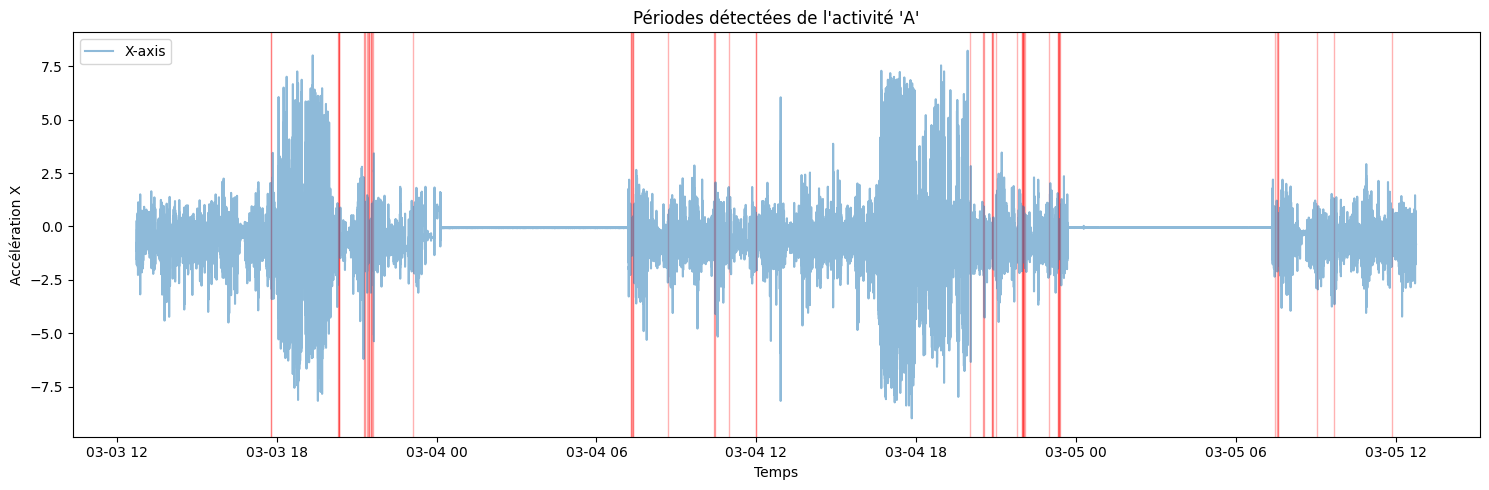

In [ ]:
import numpy as np
import pandas as pd
import scipy.signal as signal
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
import nolds

warnings.filterwarnings("ignore", category=FutureWarning)

# ==== PARAMETRES ====
fs, fc = 50, 10
window_size, step_size = 250, 125
target_activity = "A"
min_duration_sec = 20
merge_gap_sec = 5
confidence_threshold = 0.8  
# ==== FONCTIONS ====

def butter_lowpass_filter(df, columns):
    b, a = signal.butter(3, fc / (fs / 2), btype='low')
    df[columns] = signal.filtfilt(b, a, df[columns], axis=0)
    return df

def load_accel_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['date_time', 'X', 'Y', 'Z']
    df['date_time'] = pd.to_datetime(df['date_time'])
    df.set_index('date_time', inplace=True)
    return butter_lowpass_filter(df, ['X', 'Y', 'Z'])

def clean_activity_journal(filepath):
    act = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    act.columns = act.columns.str.strip()
    act['date'] = pd.to_datetime("2024-04-15") + pd.to_timedelta(act['jour'], unit='D')

    def clean_time(t):
        if pd.isna(t) or not isinstance(t, str) or t.strip() == "":
            return np.nan
        t = t.strip().replace("h", ":")
        return t if ":" in t else t + ":00"

    act['debut'] = pd.to_datetime(act['date'].astype(str) + " " + act['debut'].astype(str).apply(clean_time), errors='coerce')
    act['fin'] = pd.to_datetime(act['date'].astype(str) + " " + act['fin'].astype(str).apply(clean_time), errors='coerce')
    return act

def extract_features(segment):
    feats = []
    for axis in range(3):
        sig = segment[:, axis]
        try:
            dfa_val = nolds.dfa(sig)
        except Exception:
            dfa_val = np.nan

        feats_axis = [
            np.mean(sig),
            np.std(sig),
            np.min(sig),
            np.max(sig),
            stats.skew(sig),
            stats.kurtosis(sig),
            dfa_val
        ]
        feats_axis = [f if np.isfinite(f) else 0.0 for f in feats_axis]
        feats.extend(feats_axis)
    return feats

def segment_and_label(df, act, target="A"):
    segments, labels, features = [], [], []
    for _, row in act[act['activite'] == target].iterrows():
        segment = df.loc[row['debut']:row['fin'], ['X', 'Y', 'Z']]
        for i in range(0, len(segment) - window_size, step_size):
            window = segment.iloc[i:i + window_size].values
            segments.append(window)
            labels.append(target)
            features.append(extract_features(window))

    other_acts = act[act['activite'].isin(["P", "T", "M"])]
    for _, row in other_acts.iterrows():
        seg = df.loc[row['debut']:row['fin'], ['X', 'Y', 'Z']]
        for i in range(0, len(seg) - window_size, 500):
            window = seg.iloc[i:i + window_size].values
            if np.std(window) > 0.02:
                segments.append(window)
                labels.append(f"not_{target}")
                features.append(extract_features(window))

    return np.array(segments, dtype=np.float32), np.array(labels), np.array(features)

def postprocess_predictions(timestamps, preds, min_dur=5, merge_gap=10):
    df_preds = pd.DataFrame({'timestamp': timestamps, 'prediction': preds})
    df_preds['prediction'] = df_preds['prediction'].astype(str)

    periods = []
    current_start = None
    for i in range(len(df_preds)):
        if df_preds.loc[i, 'prediction'] == target_activity:
            if current_start is None:
                current_start = df_preds.loc[i, 'timestamp']
        else:
            if current_start:
                end_time = df_preds.loc[i - 1, 'timestamp']
                periods.append((current_start, end_time))
                current_start = None
    if current_start:
        periods.append((current_start, df_preds.iloc[-1]['timestamp']))

    cleaned = []
    for start, end in periods:
        duration = (end - start).total_seconds()
        if duration >= min_dur:
            if cleaned and (start - cleaned[-1][1]).total_seconds() <= merge_gap:
                cleaned[-1] = (cleaned[-1][0], end)
            else:
                cleaned.append((start, end))
    return cleaned

# ==== PIPELINE ====

df1 = load_accel_data('../data/Marion.lnk/MG_D.csv')
activity = clean_activity_journal('../data/activity_M.csv')
X, y, X_feat = segment_and_label(df1, activity, target=target_activity)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=len(X), ts_sz=X.shape[1], n_classes=2, l=0.1, r=1)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes, optimizer="sgd", weight_regularizer=0.01, max_iter=50, verbose=1)
shp_clf.fit(X, y_encoded)

X_shapelets = shp_clf.transform(X)
X_combined = np.hstack((X_shapelets, X_feat))

if np.isnan(X_combined).any():
    print(" NaN détectés dans X_combined, remplacement par 0.0")
    X_combined = np.nan_to_num(X_combined)

X_tr, X_val, y_tr, y_val = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=200)
clf.fit(X_tr, y_tr)

print("\n=== Classification Report (Validation) ===")
print(classification_report(y_val, clf.predict(X_val), target_names=label_encoder.classes_))

df2 = load_accel_data('../data/Marion.lnk/MG_D2.csv')
df2_filtered = df2[df2.index < df2.index.min() + pd.Timedelta(days=2)]

segments_test, timestamps_test, X_feat_test = [], [], []
for i in range(0, len(df2_filtered) - window_size, step_size):
    seg = df2_filtered.iloc[i:i + window_size][['X', 'Y', 'Z']].values
    if np.std(seg) > 0.02:
        segments_test.append(seg)
        timestamps_test.append(df2_filtered.iloc[i].name)
        X_feat_test.append(extract_features(seg))

X_test = np.array(segments_test, dtype=np.float32)
X_feat_test = np.array(X_feat_test)
X_test_transformed = shp_clf.transform(X_test)
X_test_combined = np.hstack((X_test_transformed, X_feat_test))

if np.isnan(X_test_combined).any():
    print(" NaN détectés dans X_test_combined, remplacement par 0.0")
    X_test_combined = np.nan_to_num(X_test_combined)

proba_test = clf.predict_proba(X_test_combined)
pred_indices = np.argmax(proba_test, axis=1)
pred_probs = np.max(proba_test, axis=1)
y_pred_labels = []

for idx, prob in zip(pred_indices, pred_probs):
    if prob >= confidence_threshold:
        y_pred_labels.append(label_encoder.classes_[idx])
    else:
        y_pred_labels.append(f"not_{target_activity}")

def final_prediction_summary():
    final_periods = postprocess_predictions(timestamps_test, y_pred_labels, min_dur=min_duration_sec, merge_gap=merge_gap_sec)
    df_periods = pd.DataFrame(final_periods, columns=['start_time', 'end_time'])
    df_periods['day'] = df_periods['start_time'].dt.date
    df_periods['duration'] = df_periods['end_time'] - df_periods['start_time']
    print("\n=== Périodes 'A' détectées ===")
    print(df_periods)
    df_periods.to_csv('../data/Marion.lnk/detected_A_periods.csv', index=False)
    return df_periods

final_prediction_summary()

plt.figure(figsize=(15, 5))
plt.plot(df2_filtered.index, df2_filtered['X'], label='X-axis', alpha=0.5)
for start, end in postprocess_predictions(timestamps_test, y_pred_labels, min_dur=min_duration_sec, merge_gap=merge_gap_sec):
    plt.axvspan(start, end, color='red', alpha=0.3)
plt.title("Périodes détectées de l'activité 'A'")
plt.xlabel("Temps")
plt.ylabel("Accélération X")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
activity2 = pd.read_csv('../data//Marion.lnk/journal_activite_A.csv', sep=',', skipinitialspace=True)
print(activity2)

          jour activite     debut       fin
0   2025-03-03        A  13:00:00  13:16:00
1   2025-03-03        A  16:06:00  16:16:00
2   2025-03-03        A  21:17:00  21:18:00
3   2025-03-03        A  21:23:00  21:38:00
4   2025-03-04        A  07:15:00  07:28:00
5   2025-03-04        A  11:58:00  12:12:00
6   2025-03-04        A  16:08:00  16:08:00
7   2025-03-04        A  21:39:00  22:04:00
8   2025-03-05        A  07:26:00  07:36:00
9   2025-03-05        A  11:50:00  11:50:00
10  2025-03-05        A  22:24:00  22:45:00
11  2025-03-06        A  07:26:00  07:34:00
12  2025-03-06        A  11:54:00  12:07:00


In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# === Class: Inactivity Detector ===
class InactivityDetector:
    def __init__(self, df, epoch_size=5, inactivity_threshold='dynamic', delta_threshold=0.01):
        self.df = df.copy()
        self.epoch_size = epoch_size
        self.inactivity_threshold = inactivity_threshold
        self.delta_threshold = delta_threshold
        self.processed_data = None
        self._prepare_data()
    
    def _prepare_data(self):
        self.df['acceleration'] = np.sqrt(self.df['X']**2 + self.df['Y']**2 + self.df['Z']**2)
        self.df['timestamp'] = pd.to_datetime(self.df.index)
        self.df = self.df.sort_values('timestamp')
        self.df['epoch'] = self.df['timestamp'].dt.floor(f'{self.epoch_size}s')
        self.df['date'] = self.df['timestamp'].dt.date
        self.df['delta_acc'] = self.df['acceleration'].diff().abs()
    
    def detect_inactivity(self):
        grouped = self.df.groupby(['epoch', 'date']).agg({'acceleration': 'mean', 'delta_acc': 'mean'}).reset_index()

        if self.inactivity_threshold == 'dynamic':
            mean_acc = grouped['acceleration'].mean()
            std_acc = grouped['acceleration'].std()
            threshold = max(0.1, mean_acc - 0.5 * std_acc)
        else:
            threshold = self.inactivity_threshold

        grouped['inactive'] = (grouped['acceleration'] < threshold) | (grouped['delta_acc'] < self.delta_threshold)
        grouped['inactive_group'] = (grouped['inactive'] != grouped['inactive'].shift()).cumsum()
        self.processed_data = grouped
        return grouped

# === Function: Post-processing predicted labels into time intervals ===
def postprocess_predictions(timestamps, preds, min_dur=5, merge_gap=10):
    df_preds = pd.DataFrame({'timestamp': timestamps, 'prediction': preds})
    df_preds['prediction'] = df_preds['prediction'].astype(str)

    periods = []
    current_start = None
    for i in range(len(df_preds)):
        if df_preds.loc[i, 'prediction'] == target_activity:
            if current_start is None:
                current_start = df_preds.loc[i, 'timestamp']
        else:
            if current_start:
                end_time = df_preds.loc[i - 1, 'timestamp']
                periods.append((current_start, end_time))
                current_start = None
    if current_start:
        periods.append((current_start, df_preds.iloc[-1]['timestamp']))

    cleaned = []
    for start, end in periods:
        duration = (end - start).total_seconds()
        if duration >= min_dur:
            if cleaned and (start - cleaned[-1][1]).total_seconds() <= merge_gap:
                cleaned[-1] = (cleaned[-1][0], end)
            else:
                cleaned.append((start, end))
    return cleaned

# === Function: Build DataFrame from predicted periods ===
def final_prediction_summary_fixed():
    final_periods = postprocess_predictions(timestamps_test, y_pred_labels, min_duration_sec, merge_gap_sec)
    df_periods = pd.DataFrame(final_periods, columns=['start_time', 'end_time'])
    df_periods['day'] = df_periods['start_time'].dt.date
    df_periods['duration'] = df_periods['end_time'] - df_periods['start_time']
    print("\n=== Detected 'A' periods ===")
    print(df_periods)
    df_periods.to_csv('../data/Marion.lnk/detected_A_periods.csv', index=False)
    return df_periods

# === Load acceleration data from MG_D2.csv ===
df2 = pd.read_csv('../data/Marion.lnk/MG_D2.csv')
df2.columns = ['date_time', 'X', 'Y', 'Z']
df2['date_time'] = pd.to_datetime(df2['date_time'])
df2.set_index('date_time', inplace=True)
df2['acceleration'] = np.sqrt(df2['X']**2 + df2['Y']**2 + df2['Z']**2)
df2['timestamp'] = df2.index

# === Detect inactivity ===
detector = InactivityDetector(df2, epoch_size=5, inactivity_threshold='dynamic', delta_threshold=0.01)
df_inactivity = detector.detect_inactivity()

# === Load predicted "A" activity periods ===
predicted_periods = final_prediction_summary_fixed()
predicted_periods['day'] = predicted_periods['start_time'].dt.date

# === Load real "A" activity journal ===
activity2 = pd.read_csv('../data/Marion.lnk/journal_activite_A.csv', sep=',', skipinitialspace=True)
activity2['jour'] = pd.to_datetime(activity2['jour'])
activity2['start_time'] = pd.to_datetime(activity2['jour'].astype(str) + ' ' + activity2['debut'])
activity2['end_time'] = pd.to_datetime(activity2['jour'].astype(str) + ' ' + activity2['fin'])
activity2['day'] = activity2['start_time'].dt.date

# === Get the first 2 days from df2 ===
available_days = sorted(df2.index.normalize().unique())[:2]

# === Plot each day ===
for day in available_days:
    df_day = df2[df2.index.normalize() == day]
    inactivity_day = df_inactivity[df_inactivity['date'] == day.date()]
    real_A = activity2[activity2['day'] == day.date()]
    predicted_A = predicted_periods[predicted_periods['day'] == day.date()]

    fig = go.Figure()

    # Acceleration curve
    fig.add_trace(go.Scatter(
        x=df_day.index,
        y=df_day['acceleration'],
        mode='lines',
        name='Global Acceleration',
        line=dict(color='lightgray')
    ))

    # Inactivity zones
    for _, group in inactivity_day.groupby('inactive_group'):
        if group['inactive'].iloc[0]:
            fig.add_trace(go.Scatter(
                x=group['epoch'],
                y=group['acceleration'],
                mode='lines',
                fill='tozeroy',
                fillcolor='rgba(255, 0, 0, 0.3)',
                line=dict(width=0),
                name='Inactivity'
            ))

    # Real "A" activities
    for _, row in real_A.iterrows():
        fig.add_trace(go.Scatter(
            x=[row['start_time'], row['end_time']],
            y=[2, 2],
            mode='lines',
            line=dict(color='green', width=8),
            name='True A',
            hovertemplate=f"True A<br>Start: {row['start_time']}<br>End: {row['end_time']}"
        ))

    # Predicted "A" activities
    for _, row in predicted_A.iterrows():
        fig.add_trace(go.Scatter(
            x=[row['start_time'], row['end_time']],
            y=[1.5, 1.5],
            mode='lines',
            line=dict(color='red', width=8),
            name='Predicted A',
            hovertemplate=f"Predicted A<br>Start: {row['start_time']}<br>End: {row['end_time']}"
        ))

    fig.update_layout(
        title=f"Activity A & Inactivity – {day.date()}",
        xaxis_title="Time",
        yaxis_title="Global Acceleration (g)",
        yaxis=dict(showticklabels=False),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=500,
        hovermode='x unified',
        template='plotly_white'
    )

    fig.show()


NameError: name 'timestamps_test' is not defined

In [ ]:
# VERSION BI-MAIN (main gauche + main droite)
import numpy as np
import pandas as pd
import scipy.signal as signal
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
import nolds

warnings.filterwarnings("ignore", category=FutureWarning)

fs, fc = 50, 10
window_size, step_size = 250, 125
target_activity = "A"
min_duration_sec = 20
merge_gap_sec = 5
confidence_threshold = 0.8

def butter_lowpass_filter(df, columns):
    b, a = signal.butter(3, fc / (fs / 2), btype='low')
    df[columns] = signal.filtfilt(b, a, df[columns], axis=0)
    return df

def load_accel_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['date_time', 'X', 'Y', 'Z']
    df['date_time'] = pd.to_datetime(df['date_time'])
    df.set_index('date_time', inplace=True)
    return butter_lowpass_filter(df, ['X', 'Y', 'Z'])

def clean_activity_journal(filepath):
    act = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    act.columns = act.columns.str.strip()
    act['date'] = pd.to_datetime("2024-04-15") + pd.to_timedelta(act['jour'], unit='D')
    def clean_time(t):
        if pd.isna(t) or not isinstance(t, str) or t.strip() == "":
            return np.nan
        t = t.strip().replace("h", ":")
        return t if ":" in t else t + ":00"
    act['debut'] = pd.to_datetime(act['date'].astype(str) + " " + act['debut'].astype(str).apply(clean_time), errors='coerce')
    act['fin'] = pd.to_datetime(act['date'].astype(str) + " " + act['fin'].astype(str).apply(clean_time), errors='coerce')
    return act

def extract_features(segment):
    feats = []
    for axis in range(segment.shape[1]):
        sig = segment[:, axis]
        try:
            dfa_val = nolds.dfa(sig)
        except Exception:
            dfa_val = np.nan
        feats_axis = [
            np.mean(sig), np.std(sig), np.min(sig), np.max(sig),
            stats.skew(sig), stats.kurtosis(sig), dfa_val
        ]
        feats_axis = [f if np.isfinite(f) else 0.0 for f in feats_axis]
        feats.extend(feats_axis)
    return feats

def segment_and_label(df, act, target="A"):
    segments, labels, features = [], [], []
    for _, row in act[act['activite'] == target].iterrows():
        segment = df.loc[row['debut']:row['fin']]
        for i in range(0, len(segment) - window_size, step_size):
            window = segment.iloc[i:i + window_size].values
            segments.append(window)
            labels.append(target)
            features.append(extract_features(window))
    other_acts = act[act['activite'].isin(["P", "T", "M"])]
    for _, row in other_acts.iterrows():
        seg = df.loc[row['debut']:row['fin']]
        for i in range(0, len(seg) - window_size, 500):
            window = seg.iloc[i:i + window_size].values
            if np.std(window) > 0.02:
                segments.append(window)
                labels.append(f"not_{target}")
                features.append(extract_features(window))
    return np.array(segments), np.array(labels), np.array(features)

def predict_with_model(df, clf, shp_clf, label_encoder):
    segments_test, timestamps_test, X_feat_test = [], [], []
    for i in range(0, len(df) - window_size, step_size):
        seg = df.iloc[i:i + window_size].values
        if np.std(seg) > 0.02:
            segments_test.append(seg)
            timestamps_test.append(df.iloc[i].name)
            X_feat_test.append(extract_features(seg))
    X_test = np.array(segments_test)
    X_feat_test = np.array(X_feat_test)
    X_test_transformed = shp_clf.transform(X_test)
    X_test_combined = np.hstack((X_test_transformed, X_feat_test))
    if np.isnan(X_test_combined).any():
        X_test_combined = np.nan_to_num(X_test_combined)
    proba_test = clf.predict_proba(X_test_combined)
    pred_indices = np.argmax(proba_test, axis=1)
    pred_probs = np.max(proba_test, axis=1)
    y_pred_labels = [label_encoder.classes_[idx] if prob >= confidence_threshold else f"not_{target_activity}" for idx, prob in zip(pred_indices, pred_probs)]
    return timestamps_test, y_pred_labels

def postprocess_predictions(timestamps, preds):
    df_preds = pd.DataFrame({'timestamp': timestamps, 'prediction': preds})
    periods, current_start = [], None
    for i in range(len(df_preds)):
        if df_preds.loc[i, 'prediction'] == target_activity:
            if current_start is None:
                current_start = df_preds.loc[i, 'timestamp']
        else:
            if current_start:
                end_time = df_preds.loc[i - 1, 'timestamp']
                periods.append((current_start, end_time))
                current_start = None
    if current_start:
        periods.append((current_start, df_preds.iloc[-1]['timestamp']))
    cleaned = []
    for start, end in periods:
        duration = (end - start).total_seconds()
        if duration >= min_duration_sec:
            if cleaned and (start - cleaned[-1][1]).total_seconds() <= merge_gap_sec:
                cleaned[-1] = (cleaned[-1][0], end)
            else:
                cleaned.append((start, end))
    return cleaned

def intersect_periods(periods1, periods2, tolerance_sec=5):
    result = []
    for s1, e1 in periods1:
        for s2, e2 in periods2:
            latest_start = max(s1, s2)
            earliest_end = min(e1, e2)
            if (earliest_end - latest_start).total_seconds() > tolerance_sec:
                result.append((latest_start, earliest_end))
    return result

# Chargement et entraînement pour main droite
activity = clean_activity_journal('../data/activity_M.csv')
df_d = load_accel_data('../data/Marion.lnk/MG_D.csv')
X_d, y_d, X_feat_d = segment_and_label(df_d, activity)
le_d = LabelEncoder()
y_d_encoded = le_d.fit_transform(y_d)
shapelet_sizes_d = grabocka_params_to_shapelet_size_dict(n_ts=len(X_d), ts_sz=X_d.shape[1], n_classes=2, l=0.1, r=1)
shp_d = ShapeletModel(n_shapelets_per_size=shapelet_sizes_d, optimizer="sgd", weight_regularizer=0.01, max_iter=50, verbose=0)
shp_d.fit(X_d, y_d_encoded)
X_combined_d = np.hstack((shp_d.transform(X_d), X_feat_d))
clf_d = LogisticRegression(max_iter=200).fit(X_combined_d, y_d_encoded)

# Chargement et entraînement pour main gauche
df_g = load_accel_data('../data/Marion.lnk/MG_G.csv')
X_g, y_g, X_feat_g = segment_and_label(df_g, activity)
le_g = LabelEncoder()
y_g_encoded = le_g.fit_transform(y_g)
shapelet_sizes_g = grabocka_params_to_shapelet_size_dict(n_ts=len(X_g), ts_sz=X_g.shape[1], n_classes=2, l=0.1, r=1)
shp_g = ShapeletModel(n_shapelets_per_size=shapelet_sizes_g, optimizer="sgd", weight_regularizer=0.01, max_iter=50, verbose=0)
shp_g.fit(X_g, y_g_encoded)
X_combined_g = np.hstack((shp_g.transform(X_g), X_feat_g))
clf_g = LogisticRegression(max_iter=200).fit(X_combined_g, y_g_encoded)

# Prédiction sur les 2 jours test
df_d2 = load_accel_data('../data/Marion.lnk/MG_D2.csv')
df_d2 = df_d2[df_d2.index < df_d2.index.min() + pd.Timedelta(days=2)]
df_g2 = load_accel_data('../data/Marion.lnk/MG_G2.csv')
df_g2 = df_g2[df_g2.index < df_g2.index.min() + pd.Timedelta(days=2)]

timestamps_d, preds_d = predict_with_model(df_d2, clf_d, shp_d, le_d)
timestamps_g, preds_g = predict_with_model(df_g2, clf_g, shp_g, le_g)

periods_d = postprocess_predictions(timestamps_d, preds_d)
periods_g = postprocess_predictions(timestamps_g, preds_g)

joint_periods = intersect_periods(periods_d, periods_g)
df_result = pd.DataFrame(joint_periods, columns=['start_time', 'end_time'])
df_result['day'] = df_result['start_time'].dt.date
df_result['duration'] = df_result['end_time'] - df_result['start_time']
df_result.to_csv('../data/Marion.lnk/detected_A_joint_periods.csv', index=False)

print("\n=== Périodes communes 'A' détectées (main gauche + droite) ===")
print(df_result)

# Visualisation côté main droite
plt.figure(figsize=(15, 5))
plt.plot(df_d2.index, df_d2['X'], label='X-axis main droite', alpha=0.5)
for start, end in joint_periods:
    plt.axvspan(start, end, color='red', alpha=0.3)
plt.title("Périodes détectées de l'activité 'A' - Double détection")
plt.xlabel("Temps")
plt.ylabel("Accélération X")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/3450027014.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.skew(sig), stats.kurtosis(sig), dfa_val
/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/3450027014.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.skew(sig), stats.kurtosis(sig), dfa_val
/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/3450027014.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.skew(sig), stats.kurtosis(sig), dfa_val
/var/folders/x1/bx6lyj5s5833lk_2spqyq8180000gn/T/ipykernel_1612/3450027014.py:59: RuntimeWarning:

TimeoutError: [Errno 60] Operation timed out